In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as st

In [3]:
def date_of_birth_to_age(dataframe):
    dataframe['DateOfBirth'] = dataframe['DateOfBirth'].fillna("NaT").apply(lambda x: datetime.strptime(str(x)[:10],'%Y-%m-%d') if str(x) != "NaT" else "NaT")
    dataframe['DateOfBirth'] = dataframe['DateOfBirth'].apply(lambda x: datetime.timestamp(datetime.today()) - datetime.timestamp(x) if str(x) != "NaT" else "NaT")
    dataframe['DateOfBirth'] = dataframe['DateOfBirth'].apply(lambda x: round(x/31536000,4) if str(x) != "NaT" else np.nan)
    dataframe["Age"] = dataframe["DateOfBirth"]
    return dataframe

In [4]:
# Fetch Dataframes from sources
data = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/task_3_4.csv.gz')
subjects = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/subject_metadata.csv.gz')
questions = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/question_metadata_task_3_4.csv.gz')
students = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/student_metadata_task_3_4.csv.gz')
answers = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/answer_metadata_task_3_4.csv.gz')

# Merge to create one useful df
df = pd.merge(data, answers, on='AnswerId', how='inner')
df = pd.merge(df, students, on='UserId', how='inner')

# Change 'DateOfBirth' to more sensible feature 'Age'
df = date_of_birth_to_age(df)
df.drop(['DateOfBirth'], axis=1, inplace=True)

# Add Missing Indicators for model
df['Missing Confidence'] = np.where(df['Confidence'].isna(), True, False)
df['Missing Gender'] = np.where(df['Gender'] == 0, True, False)
df['Missing SchemeOfWorkId'] = np.where(df['SchemeOfWorkId'].isna(), True, False)
df['Missing PremiumPupil'] = np.where(df['PremiumPupil'].isna(), True, False)
df['Missing Age'] = np.where(df['Age'].isna(), True, False)

In [209]:
df_r = df.drop(["DateAnswered","QuestionId","CorrectAnswer","AnswerValue","GroupId","QuizId","SchemeOfWorkId","Missing Confidence","Missing Gender","Missing SchemeOfWorkId","Missing PremiumPupil","Missing Age"], axis=1)
df_r = df_r.dropna()
answer_counts = pd.DataFrame(df_r.groupby(['UserId'], as_index=False).size())
df_r = df_r.groupby(['UserId'], as_index=False).mean()
df_r = df_r.rename(columns={'Confidence':'AverageConfidence','IsCorrect':'AverageCorrect'})
df_r['isMale'] = np.where(df_r['Gender'] == 2, 1, 0)
df_r = df_r.drop(["Gender", "AnswerId"], axis=1)

df_reg = pd.merge(df_r, answer_counts, how='inner',on='UserId')
df_reg = df_reg.rename(columns={0:'AnswerCount'})
df_reg = df_reg.drop(["UserId"], axis=1)


In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382727 entries, 0 to 1382726
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   QuestionId              1382727 non-null  int64  
 1   UserId                  1382727 non-null  int64  
 2   AnswerId                1382727 non-null  int64  
 3   IsCorrect               1382727 non-null  int64  
 4   CorrectAnswer           1382727 non-null  int64  
 5   AnswerValue             1382727 non-null  int64  
 6   DateAnswered            1382727 non-null  object 
 7   Confidence              346428 non-null   float64
 8   GroupId                 1382727 non-null  int64  
 9   QuizId                  1382727 non-null  int64  
 10  SchemeOfWorkId          1267192 non-null  float64
 11  Gender                  1382727 non-null  int64  
 12  PremiumPupil            707860 non-null   float64
 13  Age                     727345 non-null   float64
 14  Mi

In [245]:
len(df['UserId'].unique())

4918

In [246]:
len(df['QuestionId'].unique())

948

In [210]:
df.isnull().sum()

QuestionId                      0
UserId                          0
AnswerId                        0
IsCorrect                       0
CorrectAnswer                   0
AnswerValue                     0
DateAnswered                    0
Confidence                1036299
GroupId                         0
QuizId                          0
SchemeOfWorkId             115535
Gender                          0
PremiumPupil               674867
Age                        655382
Missing Confidence              0
Missing Gender                  0
Missing SchemeOfWorkId          0
Missing PremiumPupil            0
Missing Age                     0
dtype: int64

## Question Distribution by Average Confidence

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


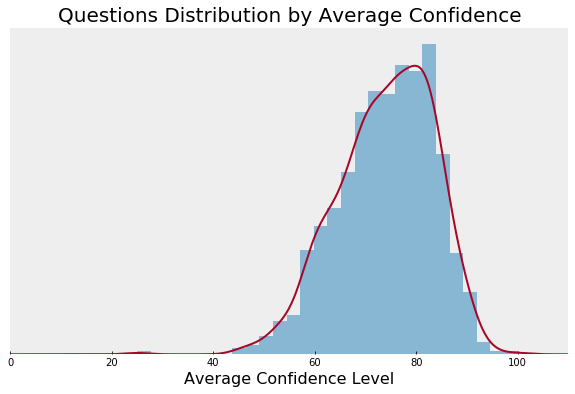

In [211]:
# Show distribution of questions by average confidence level
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
ConfidenceByQuestion = df.groupby(["QuestionId"])["Confidence"].mean()
# Plots
CbQ = plt.hist(ConfidenceByQuestion, bins='auto', density=True, alpha=0.55)
CbQkde = ConfidenceByQuestion.plot(kind = "kde")
# Extras
ax.set_xlabel("Average Confidence Level", fontsize=16)
ax.set_xlim(0, 110)
ax.set_title("Questions Distribution by Average Confidence", size=20)
ax.set_yticks([])
ax.set_ylabel("")
ax.grid(False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

## User Distribution by Average Confidence

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


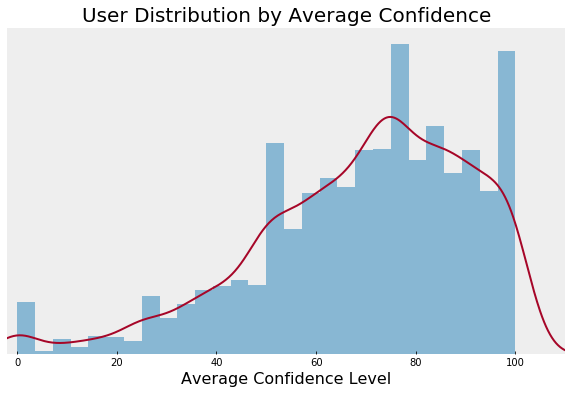

In [7]:
# Show distribution of users by average confidence level
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
ConfidenceByUser = df.groupby(["UserId"])["Confidence"].mean()
# Plots
CbU = plt.hist(ConfidenceByUser, bins='auto', density=True, alpha=0.55)
CbUkde = ConfidenceByUser.plot(kind = "kde")
# Extras
ax.set_xlabel("Average Confidence Level", fontsize=16)
ax.set_xlim(-2, 110)
ax.set_title("User Distribution by Average Confidence", fontsize=20)
ax.set_yticks([])
ax.set_ylabel("")
ax.grid(False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

## User Distribution by Proportion of Correct Answers

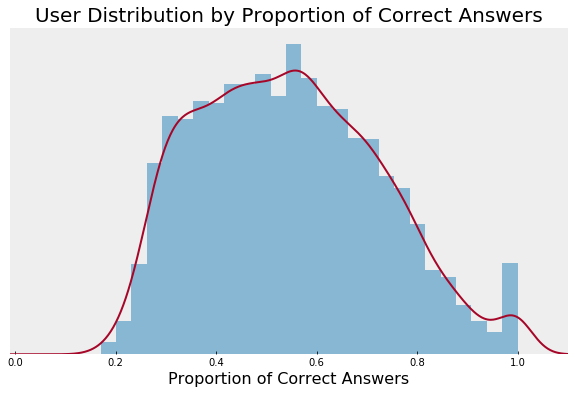

In [8]:
# Show distribution of correct answers by user
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
CorrectByUser = df.groupby(["UserId"])["IsCorrect"].mean()
# Plots
CorbU = plt.hist(CorrectByUser, bins='auto', density=True, alpha=0.55)
CorbUkde = CorrectByUser.plot(kind = "kde")
# Extras
ax.set_xlabel("Proportion of Correct Answers", fontsize=16)
ax.set_xlim(-0.01, 1.1)
ax.set_title("User Distribution by Proportion of Correct Answers", fontsize=20)
ax.set_yticks([])
ax.set_ylabel("")
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

## Question Distribution by Proportion of Correct Answers

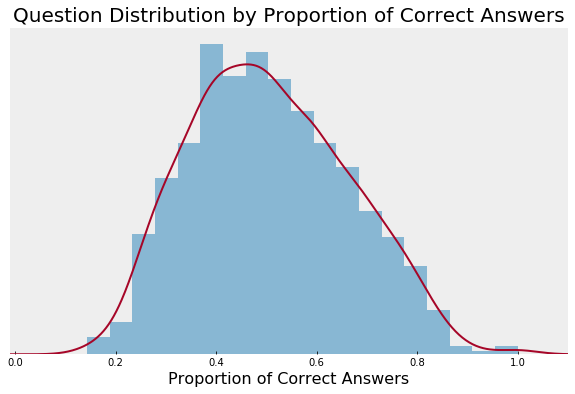

In [9]:
CorrectByQuestion = df.groupby(["QuestionId"])["IsCorrect"].mean()
# Show distribution of correct answers by user
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
CorrectByQuestion = df.groupby(["QuestionId"])["IsCorrect"].mean()
# Plots
CorbQ = plt.hist(CorrectByQuestion, bins='auto', density=True, alpha=0.55)
CorbQkde = CorrectByQuestion.plot(kind = "kde")
# Extras
ax.set_xlabel("Proportion of Correct Answers", fontsize=16)
ax.set_xlim(-0.01, 1.1)
ax.set_title("Question Distribution by Proportion of Correct Answers", fontsize=20)
ax.set_yticks([])
ax.set_ylabel("")
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

## Distributions of Proportion of Correct Answers by Age Group

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


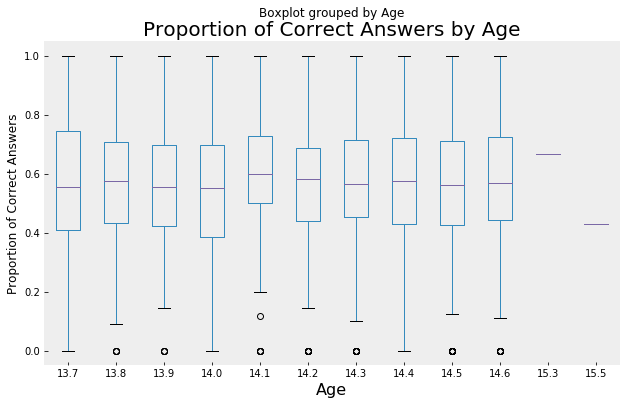

In [147]:
# Show distribution of correct answers by age group
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
CorrectbyAge = df_reg[['AverageCorrect', 'Age']]
CorrectbyAge['Age'] = CorrectbyAge['Age'].round(1)
# Plots
CorrectbyAge.boxplot(by='Age', ax=ax)
# Extras
ax.set_xlabel("Age", fontsize=16)
ax.set_title("Proportion of Correct Answers by Age", fontsize=20)
ax.set_ylabel("Proportion of Correct Answers")
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

## Distributions of Average Confidence by Age Group

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


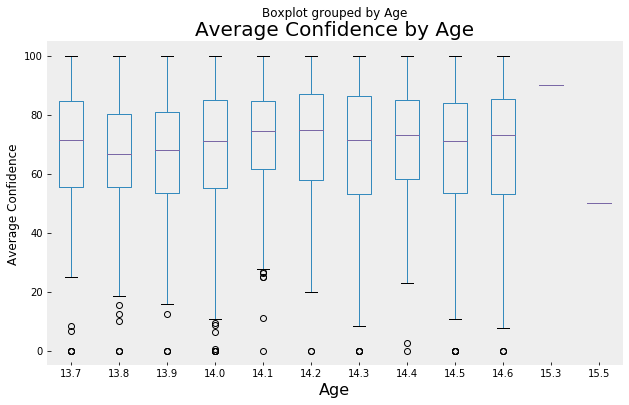

In [155]:
# Show distribution of confidence by age group
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
CorrectbyAge = df_reg[['AverageConfidence', 'Age']]
CorrectbyAge['Age'] = CorrectbyAge['Age'].round(1)
# Plots
CorrectbyAge.boxplot(by='Age', ax=ax)
# Extras
ax.set_xlabel("Age", fontsize=16)
ax.set_title("Average Confidence by Age", fontsize=20)
ax.set_ylabel("Average Confidence")
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

## User Frequency Distribution

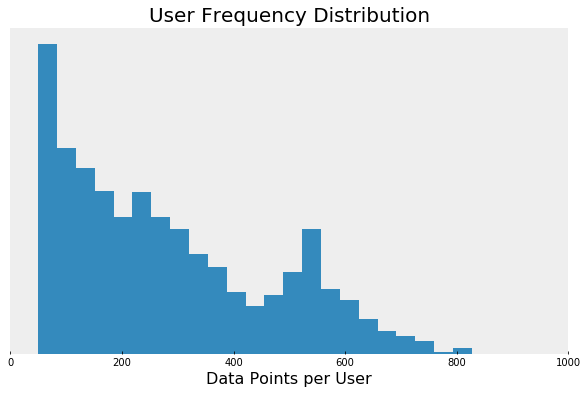

In [12]:
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
users , userCts = np.unique(df["UserId"], return_counts=True)

# Plots
user_dist = plt.hist(userCts, bins='auto')
#
ax.set_xlabel("Data Points per User", fontsize=16)
ax.set_xlim(-0.01, 1000)
ax.set_title("User Frequency Distribution", fontsize=20)
ax.set_yticks([])
ax.set_ylabel("")
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

## Confidence Level Distribution

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:403: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:404: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


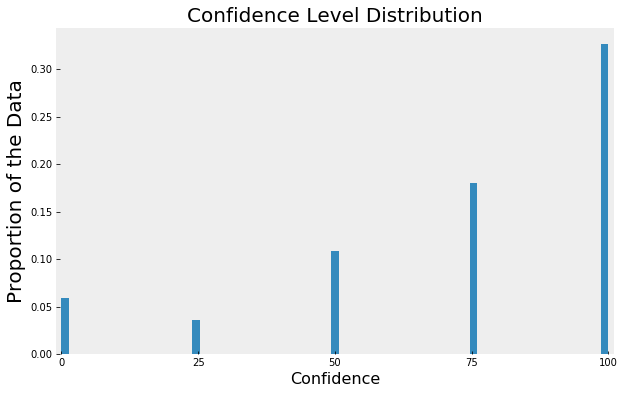

In [152]:
# Show distribution of correct answers by user
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Plots
Confidence_dist = plt.hist(df["Confidence"], bins='auto', density=True)
# Extras
ax.set_xlabel("Confidence", fontsize=16)
ax.set_xlim(-1, 101)
ax.set_title("Confidence Level Distribution", fontsize=20)
ax.set_xticks([0,25,50,75,100])
ax.set_ylabel("Proportion of the Data", size=20)
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

## Proportion of Correct Answers by Confidence Level

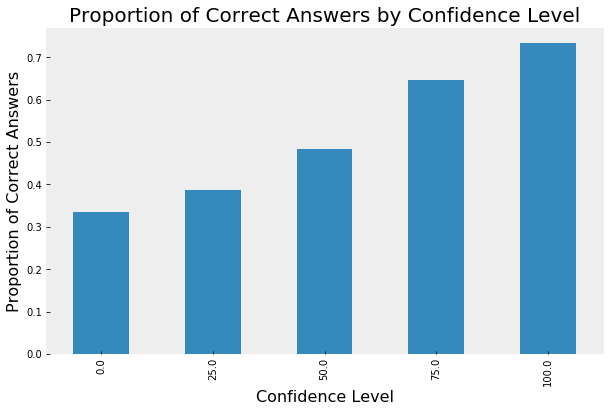

In [153]:
# Show distribution of correct answers by confidence level
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
CorrectByConfidence = df.groupby(["Confidence"])["IsCorrect"].mean()
# Plots
CorrectByConfidence.plot.bar();
# Extras
ax.set_ylabel("Proportion of Correct Answers", fontsize=16)
ax.set_title("Proportion of Correct Answers by Confidence Level", fontsize=20)
ax.set_xlabel("Confidence Level", size=16)
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

## Average Confidence Level by Gender and T-Test

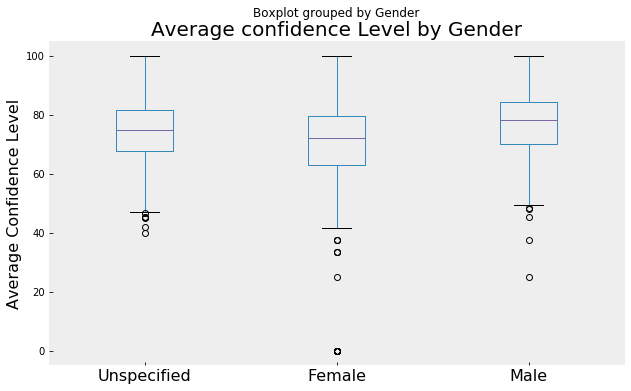

In [16]:
# Average Confidence by Gender
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
df2 = df[["QuestionId", "Gender","Confidence"]]
# Gender 3 has only missing confidences and only ~ 500 points
df2 = df2.drop(df2[df2.Gender == 3].index)
CorrectByConfGiven = df2.groupby(["QuestionId", "Gender"]).mean()
# Plots
CorrectByConfGiven.boxplot(by='Gender', ax=ax);
# Extras
ax.set_xticklabels(["Unspecified", "Female", "Male"], size=16)
ax.set_xlabel("", fontsize=16)
ax.set_title("Average confidence Level by Gender", fontsize=20)
ax.set_ylabel("Average Confidence Level", size=16)
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [232]:
gender_confidence = df_reg[["isMale","AverageConfidence"]]

a = gender_confidence.loc[gender_confidence['isMale'] == 1, 'AverageConfidence'].to_numpy()
b = gender_confidence.loc[gender_confidence['isMale'] == 0, 'AverageConfidence'].to_numpy()
gender_confidence

,isMale,AverageConfidence
0,0,89.285714
1,0,66.836735
2,1,50.000000
3,0,55.943152
4,1,68.965517
...,...,...
1895,0,67.857143
1896,1,77.727273
1897,1,68.478261
1898,1,81.501548


In [233]:
# T-Test for if average confidence difference between genders is significant
st.ttest_ind(a,b)

Ttest_indResult(statistic=4.391620709112137, pvalue=1.1870709989386407e-05)

## Proportion of Correct Answers by Gender and T-Test

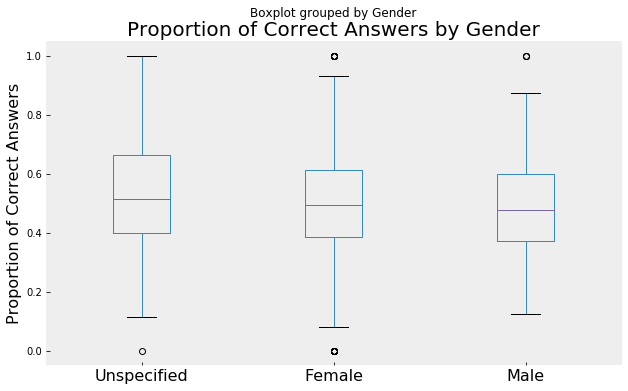

In [17]:
# Proportion of Correct Answers by Gender
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
df2 = df[["QuestionId", "Gender","IsCorrect"]]
# Gender 3 has only missing confidences and only ~ 500 points
df2 = df2.drop(df2[df2.Gender == 3].index)
CorrectByConfGiven = df2.groupby(["QuestionId", "Gender"]).mean()
# Plots
CorrectByConfGiven.boxplot(by='Gender', ax=ax);
# Extras
ax.set_xticklabels(["Unspecified", "Female", "Male"], size=16)
ax.set_xlabel("", fontsize=16)
ax.set_title("Proportion of Correct Answers by Gender", fontsize=20)
ax.set_ylabel("Proportion of Correct Answers", size=16)
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [230]:
gender_correct = df_reg[["isMale","AverageCorrect"]]

a = gender_correct.loc[gender_correct['isMale'] == 1, 'AverageCorrect'].to_numpy()
b = gender_correct.loc[gender_correct['isMale'] == 0, 'AverageCorrect'].to_numpy()
gender_correct

,isMale,AverageCorrect
0,0,1.000000
1,0,0.591837
2,1,0.800000
3,0,0.467700
4,1,0.482759
...,...,...
1895,0,0.642857
1896,1,0.545455
1897,1,0.434783
1898,1,0.566563


In [231]:
# T-Test for if proportion of correct answers difference between genders is significant
st.ttest_ind(a,b)

Ttest_indResult(statistic=-0.4211267828786388, pvalue=0.6737101875275029)

## Proportion of Correct Answers by Missing Confidence and T-Test

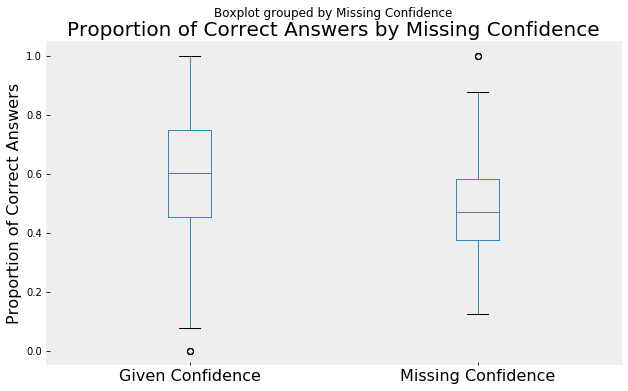

In [18]:
# Show distribution of correct answers by missing confidence level
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
df2 = df[["QuestionId", "Missing Confidence","IsCorrect"]]
CorrectByConfGiven = df2.groupby(["QuestionId", "Missing Confidence"]).mean()
# Plots
CorrectByConfGiven.boxplot(by='Missing Confidence', ax=ax);
# Extras
ax.set_xticklabels(["Given Confidence", "Missing Confidence"], size=16)
ax.set_xlabel("", fontsize=16)
ax.set_title("Proportion of Correct Answers by Missing Confidence", fontsize=20)
ax.set_ylabel("Proportion of Correct Answers", size=16)
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [228]:
correct_missing = df[["QuestionId", "IsCorrect","Missing Confidence"]].groupby(["QuestionId", "Missing Confidence"],as_index=False).mean()
correct_missing = correct_missing.drop(["QuestionId"], axis=1)

a = correct_missing.loc[correct_missing['Missing Confidence'] == False, 'IsCorrect'].to_numpy()
b = correct_missing.loc[correct_missing['Missing Confidence'] == True, 'IsCorrect'].to_numpy()
correct_missing

,Missing Confidence,IsCorrect
0,False,0.459804
1,True,0.434152
2,True,0.571429
3,False,0.419628
4,True,0.373403
...,...,...
1847,True,0.398837
1848,False,0.588235
1849,True,0.436170
1850,False,0.798077


In [229]:
# T-Test for if proportion of correct answers difference between missing confidence and given confidence is significant
st.ttest_ind(a,b)

Ttest_indResult(statistic=13.69515367408709, pvalue=9.800962944354537e-41)

## Proportion of Correct Answers by Confidence Level

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


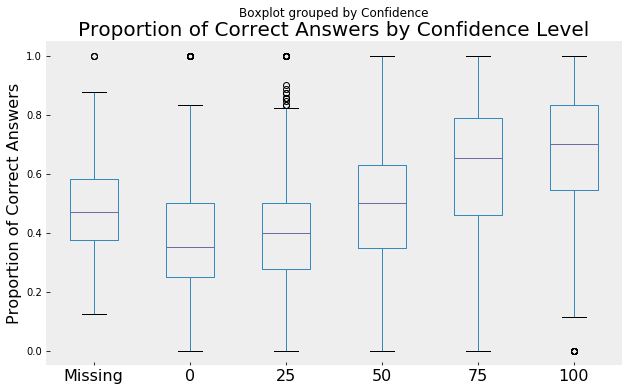

In [19]:
# Show distribution of correct answers by confidence level
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
df2 = df[["QuestionId", "IsCorrect","Confidence"]]
df2.loc[df["Missing Confidence"],"Confidence"] = -1
CorrectByConfidence = df2.groupby(["QuestionId", "Confidence"]).mean()
# Plots
CorrectByConfidence.boxplot(by='Confidence', ax=ax)
# Extras
ax.set_xticklabels(["Missing", "0", "25","50","75","100"], size=16)
ax.set_xlabel("", fontsize=16)
ax.set_title("Proportion of Correct Answers by Confidence Level", fontsize=20)
ax.set_ylabel("Proportion of Correct Answers", size=16)
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

## Proportion of Correct Answers by Income Support and T-Test

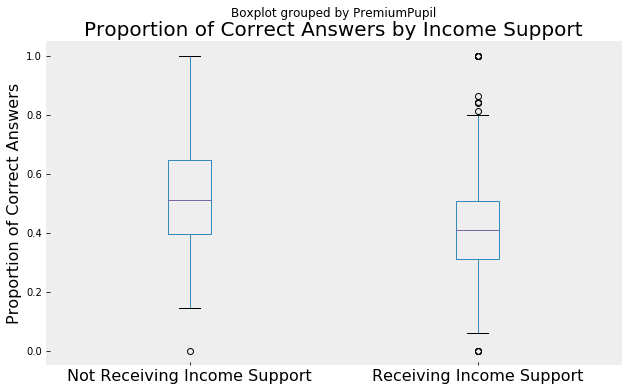

In [80]:
# Proportion of Correct Answers by PremiumPupil
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
df2 = df[["QuestionId", "PremiumPupil","IsCorrect"]]
# Gender 3 has only missing confidences and only ~ 500 points
CorrectByConfGiven = df2.groupby(["QuestionId", "PremiumPupil"]).mean()
# Plots
CorrectByConfGiven.boxplot(by='PremiumPupil', ax=ax);
# Extras
ax.set_xticklabels(["Not Receiving Income Support", "Receiving Income Support"], size=16)
ax.set_xlabel("", fontsize=16)
ax.set_title("Proportion of Correct Answers by Income Support", fontsize=20)
ax.set_ylabel("Proportion of Correct Answers", size=16)
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [215]:
correct_pp = df_reg[["PremiumPupil","AverageCorrect"]]


a = correct_pp.loc[correct_pp['PremiumPupil'] == 0, 'AverageCorrect'].to_numpy()
b = correct_pp.loc[correct_pp['PremiumPupil'] == 1, 'AverageCorrect'].to_numpy()
correct_pp

,PremiumPupil,AverageCorrect
0,0.0,1.000000
1,0.0,0.591837
2,1.0,0.800000
3,1.0,0.467700
4,0.0,0.482759
...,...,...
1895,1.0,0.642857
1896,0.0,0.545455
1897,0.0,0.434783
1898,0.0,0.566563


In [216]:
# T-Test for if proportion of correct answers difference between Income Support and No Income Support is significant
st.ttest_ind(a,b)

Ttest_indResult(statistic=6.059492137428141, pvalue=1.6426781836661457e-09)

## Average Confidence by Income Support and T-Test

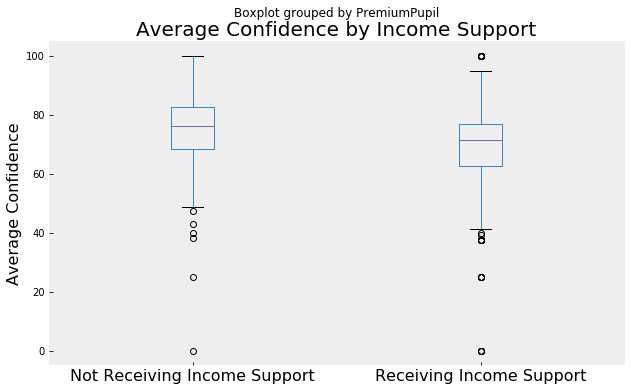

In [81]:
# Average Confidence Level by PremiumPupil
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
df2 = df[["QuestionId", "PremiumPupil","Confidence"]]
# Gender 3 has only missing confidences and only ~ 500 points
CorrectByConfGiven = df2.groupby(["QuestionId", "PremiumPupil"]).mean()
# Plots
CorrectByConfGiven.boxplot(by='PremiumPupil', ax=ax);
# Extras
ax.set_xticklabels(["Not Receiving Income Support", "Receiving Income Support"], size=16)
ax.set_xlabel("", fontsize=16)
ax.set_title("Average Confidence by Income Support", fontsize=20)
ax.set_ylabel("Average Confidence", size=16)
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [213]:
confidence_pp = df_reg[["PremiumPupil","AverageConfidence"]]


a = confidence_pp.loc[confidence_pp['PremiumPupil'] == 0, 'AverageConfidence'].to_numpy()
b = confidence_pp.loc[confidence_pp['PremiumPupil'] == 1, 'AverageConfidence'].to_numpy()
confidence_pp

,PremiumPupil,AverageConfidence
0,0.0,89.285714
1,0.0,66.836735
2,1.0,50.000000
3,1.0,55.943152
4,0.0,68.965517
...,...,...
1895,1.0,67.857143
1896,0.0,77.727273
1897,0.0,68.478261
1898,0.0,81.501548


In [214]:
# T-Test for if average confidence difference between Income Support and No Income Support is significant
st.ttest_ind(a,b)

Ttest_indResult(statistic=3.3903554398078533, pvalue=0.0007123182813523616)

## Average Confidence of Correct Answers by Average Confidence of Incorrect Answers

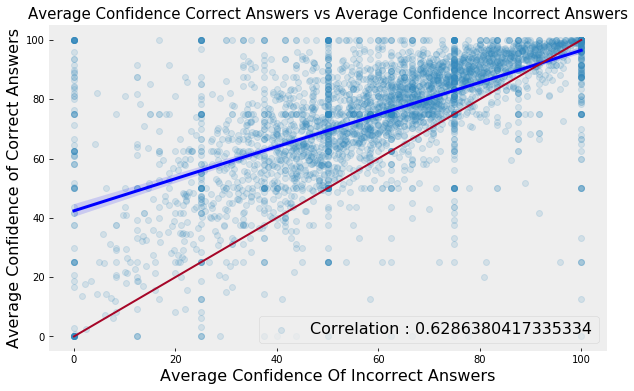

In [249]:
students_confidence = df.groupby(["UserId", "IsCorrect"]).agg(
    MeanConfidence=("Confidence", np.mean)
).unstack().rename(columns = {
    0: "MeanConfidenceIncorrectAnswers", 
    1: "MeanConfidenceCorrectAnswers"
}, level = 1)
students_confidence.columns = students_confidence.columns.droplevel(0)
students_confidence["ConfidenceDifference"] = students_confidence["MeanConfidenceCorrectAnswers"] \
    - students_confidence["MeanConfidenceIncorrectAnswers"]
students_confidence = students_confidence.dropna()
# Show distribution of correct answers by user
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Plots
cor = ("Correlation : " + str(np.corrcoef(students_confidence['MeanConfidenceCorrectAnswers'],students_confidence['MeanConfidenceIncorrectAnswers'])[0][1]))
sns.regplot(students_confidence['MeanConfidenceIncorrectAnswers'],students_confidence['MeanConfidenceCorrectAnswers'], label= cor, scatter_kws={'alpha':0.15}, line_kws={'color': 'b'})
plt.plot([0, 100], [0, 100], linewidth=2)
# Extras
ax.set_xlabel("Average Confidence Of Incorrect Answers", fontsize=16)
ax.set_title("Average Confidence Correct Answers vs Average Confidence Incorrect Answers", fontsize=15)
ax.set_ylabel("Average Confidence of Correct Answers", size=16)
ax.grid(False)
ax.legend(prop={'size': 16})

for ax, spine in ax.spines.items():
    spine.set_visible(False)


## Proportion of correct Answers by Average Confidence

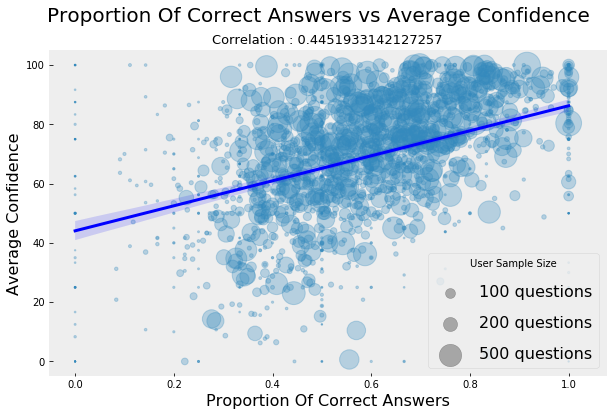

In [120]:
# Show distribution of correct answers by user
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Plots
cor = ("Correlation : " + str(np.corrcoef(df_reg['AverageCorrect'],df_reg['AverageConfidence'])[1][0]))
sns.regplot(df_reg['AverageCorrect'], df_reg['AverageConfidence'], scatter_kws={'alpha':0.3, 's': df_reg['AnswerCount']}, line_kws={'color': 'b'})
# Extras
ax.set_xlabel("Proportion Of Correct Answers", fontsize=16)
ax.set_title(cor, size=13)
ax.set_ylabel("Average Confidence", size=16)
ax.grid(False)
plt.suptitle("Proportion Of Correct Answers vs Average Confidence", fontsize=20)
for ss in [100, 200, 500]:
    plt.scatter([], [], c='k', alpha=0.3, s=ss,
                label=str(ss) + ' questions')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='User Sample Size', prop={'size': 16})

for ax, spine in ax.spines.items():
    spine.set_visible(False)


## Average Confidence by Age

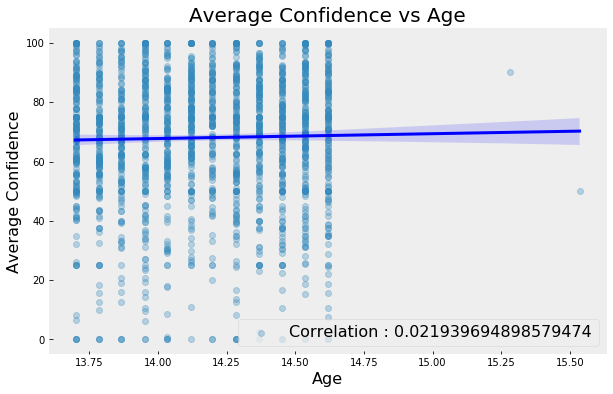

In [59]:
# Show distribution of correct answers by user
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Plots
cor = ("Correlation : " + str(np.corrcoef(df_reg['Age'],df_reg['AverageConfidence'])[1][0]))
sns.regplot(df_reg['Age'], df_reg['AverageConfidence'], label= cor, scatter_kws={'alpha':0.3, 's':}, line_kws={'color': 'b'})
# Extras
ax.set_xlabel("Age", fontsize=16)
ax.set_title("Average Confidence vs Age", fontsize=20)
ax.set_ylabel("Average Confidence", size=16)
ax.grid(False)
ax.legend(prop={'size': 16})

for ax, spine in ax.spines.items():
    spine.set_visible(False)


## Average Confidence of Premium Pupils by Genders Distributions and T-Test

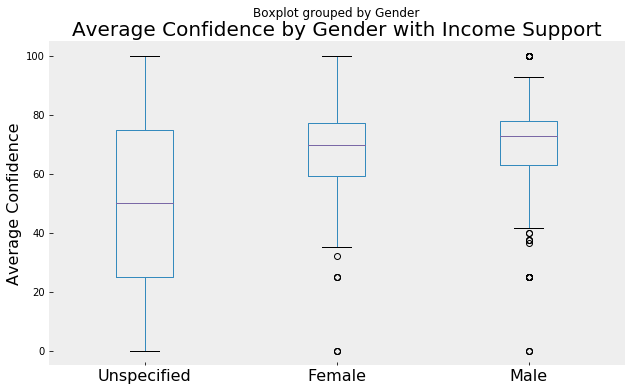

In [174]:
# PremiumPupil Average confidence by Gender
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Data
df2 = df[["QuestionId","PremiumPupil", "Gender","Confidence"]]
# Gender 3 has only missing confidences and only ~ 500 points
pp = df2['PremiumPupil'] == 1
df2 = df2[pp]
df2 = df2.drop(['PremiumPupil'], axis=1)
PPConBGen = df2.groupby(["QuestionId","Gender"]).mean()
# Plots
PPConBGen.boxplot(by='Gender', ax=ax);
# Extras
ax.set_xticklabels(["Unspecified", "Female", "Male"], size=16)
ax.set_xlabel("", fontsize=16)
ax.set_title("Average Confidence by Gender with Income Support", fontsize=20)
ax.set_ylabel("Average Confidence", size=16)
ax.grid(False)

for ax, spine in ax.spines.items():
    spine.set_visible(False)

In [203]:
pp_gender_confidence = df_reg[["PremiumPupil", "isMale","AverageConfidence"]]
pp = pp_gender_confidence['PremiumPupil'] == 1
pp_gender_confidence = pp_gender_confidence[pp]
pp_gender_confidence = pp_gender_confidence.drop(['PremiumPupil'], axis=1)


a = pp_gender_confidence.loc[pp_gender_confidence['isMale'] == 1, 'AverageConfidence'].to_numpy()
b = pp_gender_confidence.loc[pp_gender_confidence['isMale'] == 0, 'AverageConfidence'].to_numpy()
pp_gender_confidence

,isMale,AverageConfidence
2,1,50.000000
3,0,55.943152
8,0,40.000000
10,1,69.014085
11,1,73.616236
...,...,...
1884,1,93.181818
1888,1,0.000000
1892,1,100.000000
1895,0,67.857143


In [208]:
# T-Test for if average confidence difference between Male and Female is significant
st.ttest_ind(a,b)

Ttest_indResult(statistic=1.721891330178402, pvalue=0.08566186023104047)

## Ordinary Least Squares Linear Regression

In [581]:
model_simple = smf.ols(formula="AverageConfidence~PremiumPupil+Age+isMale+AverageCorrect", data=df_reg)
result_simple = model_simple.fit()
print(result_simple.summary())

                            OLS Regression Results                            
Dep. Variable:      AverageConfidence   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     125.7
Date:                Sat, 09 Apr 2022   Prob (F-statistic):           2.79e-95
Time:                        15:22:24   Log-Likelihood:                -8347.2
No. Observations:                1900   AIC:                         1.670e+04
Df Residuals:                    1895   BIC:                         1.673e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         23.8236     21.475      1.

## Weighted Least Squares Linear Regression

In [236]:
X=df_reg[["PremiumPupil","Age","isMale","AverageCorrect"]]
Y=df_reg["AverageConfidence"]

mod_wls = sm.WLS(Y,X , weights=df_reg['AnswerCount'])
res_wls = mod_wls.fit()
print(res_wls.summary())

                                 WLS Regression Results                                
Dep. Variable:      AverageConfidence   R-squared (uncentered):                   0.953
Model:                            WLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                              9692.
Date:                Sun, 10 Apr 2022   Prob (F-statistic):                        0.00
Time:                        22:28:53   Log-Likelihood:                         -9057.9
No. Observations:                1900   AIC:                                  1.812e+04
Df Residuals:                    1896   BIC:                                  1.815e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

## Ordinary Least Squares Linear Regression with 2-way interactions

In [237]:
model_pairwise = smf.ols(formula="AverageConfidence~(AverageCorrect+Age+isMale+PremiumPupil)**2", data=df_reg)
result_pairwise = model_pairwise.fit()
print(result_pairwise.summary())

                            OLS Regression Results                            
Dep. Variable:      AverageConfidence   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     51.17
Date:                Sun, 10 Apr 2022   Prob (F-statistic):           3.36e-91
Time:                        22:30:50   Log-Likelihood:                -8343.1
No. Observations:                1900   AIC:                         1.671e+04
Df Residuals:                    1889   BIC:                         1.677e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

## Regularized Estimates of Averages

Whenever we show distributions of aggregated metrics such as proportions of correct answers or average confidence per user, we face the issue of low counts. Those low sample sizes often result in unreliable estimates of $\hat{p} = k/n$ and a higher occurrence of extremely high or low averages.

In Bayesian statistics, one way around this would be to "shrink" the estimates toward a so-called *prior distribution*, which either comes from 

1. prior knowledge or theory
2. the data themselves

The latter approach is referred to as *empirical Bayes*.

For binary data we adopt the beta prior distribution as the conjugate to the binomial. So, let us fit a beta distribution to the "proportion of correct answers" of users with at least 10 counts:

In [238]:
CorrectByUser = df.groupby(["UserId"])["IsCorrect"].mean()
SizeByUser = df.groupby(["UserId"])["IsCorrect"].size()
CorrectByUser.describe()

count    4918.000000
mean        0.545409
std         0.180538
min         0.170000
25%         0.401766
50%         0.536894
75%         0.673132
max         1.000000
Name: IsCorrect, dtype: float64

2.3670739513873675 3.845060675717896 0.16778620283907075 0.9923098394650895


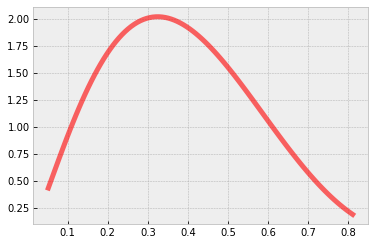

In [239]:
from scipy import stats 
from scipy.stats import beta
import matplotlib.pyplot as plt
#fit the parameter
a,b,c,d = stats.beta.fit(CorrectByUser[SizeByUser>9])
#plot the beta distribution
fig, ax = plt.subplots(1, 1)

x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='beta pdf')
print(a,b,c,d)

We found the parameters of our beta prior distribution to be $\alpha_0 = 2.367$ and $\beta_0 = 3.845$. Following this [SE post on the beta distribution](https://stats.stackexchange.com/questions/47771/what-is-the-intuition-behind-beta-distribution) we now compute the "shrunken proportions as 
$$
\hat{p}_s = \frac{k + \alpha_0}{n + \alpha_0+ \beta_0}
$$
where $k$ is the number of correct answers and $n$ is the total number of questions answered by user.

Let us recompute the histogram:

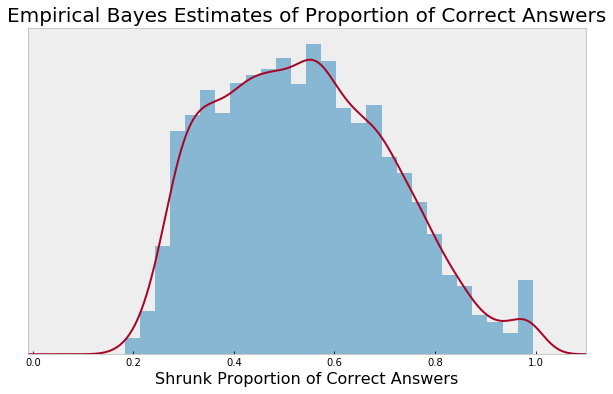

In [241]:
k = CorrectByUser*SizeByUser

CorrectByUserShrunk = (k+a)/(SizeByUser+a+b)


# Show distribution of correct answers by user
fig, ax = plt.subplots(figsize = (10,6))
plt.style.use("bmh")
# Plots
CorbU = plt.hist(CorrectByUserShrunk, bins='auto', density=True, alpha=0.55)
CorbUkde = CorrectByUserShrunk.plot(kind = "kde")
# Extras
ax.set_xlabel("Shrunk Proportion of Correct Answers", fontsize=16)
ax.set_xlim(-0.01, 1.1)
ax.set_title("Empirical Bayes Estimates of Proportion of Correct Answers", fontsize=20)
ax.set_yticks([])
ax.set_ylabel("")
ax.grid(False)

In [250]:
pip install dtreeviz 

  Created wheel for dtreeviz: filename=dtreeviz-1.3.5-py3-none-any.whl size=67335 sha256=f8ed375fdb806757946c0b627b076d88aac1df840a4d676f505c85f4024fb9ae
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\9d\84\55\4de0a214e0b9d21a96fc343b4a85547f3dab815a49682dfeb2
Successfully built dtreeviz
Note: you may need to restart the kernel to use updated packages.


## Decision Tree

In [251]:
from sklearn import tree
from dtreeviz.trees import *

regr = tree.DecisionTreeRegressor(max_depth=3)
regr.fit(X, Y)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

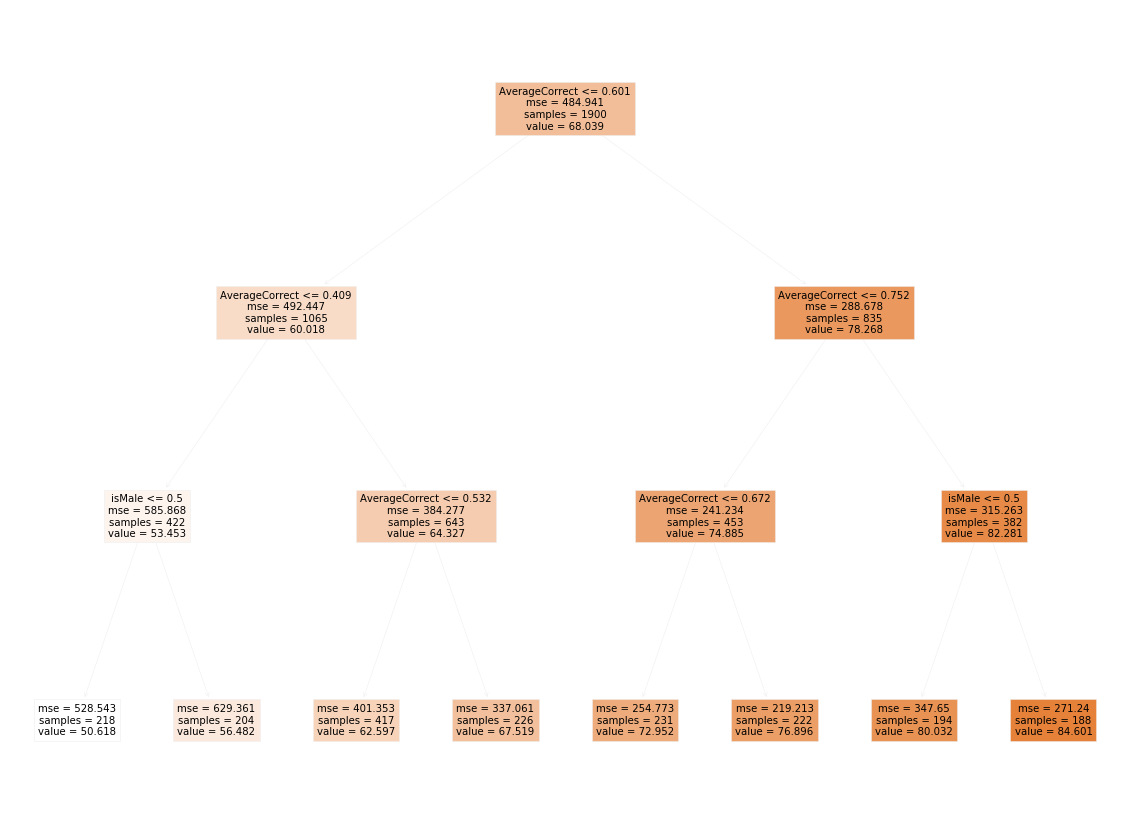

In [253]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]

fig = plt.figure(figsize=(20,15))
_=tree.plot_tree(regr, feature_names=X.columns,  filled=True)